## 数据预处理

In [1]:
import os
import numpy as np
import torch
import json


# 设置随机数生成器种子
seed = 24
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


def read_classes(classes_file_path):
    """
    从classes.txt文件中读取类别列表
    Args:
        classes_file_path (str): classes.txt文件路径

    Returns:
        list: 类别列表
    """
    with open(classes_file_path, 'r') as file:
        classes = file.readline().strip().split()
    return classes


def read_labels(label_file_path, num_classes):
    """
    从label文件中读取独热码标签
    Args:
        label_file_path (str): 标签文件路径
        num_classes (int): 类别数量

    Returns:
        np.array: 独热码标签
    """
    with open(label_file_path, 'r') as file:
        line = file.readline().strip()
        labels = [int(x) for x in line.split()]
    return np.array(labels)


def load_dataset(dataset_folder):
    """
    加载多标签分类数据集
    Args:
        dataset_folder (str): 数据集文件夹路径

    Returns:
        list, list: 图像路径列表，标签列表
    """
    images_folder = os.path.join(dataset_folder, 'images')
    labels_folder = os.path.join(dataset_folder, 'labels')
    classes_file_path = os.path.join(dataset_folder, 'classes.txt')

    classes = read_classes(classes_file_path)

    image_paths = []
    labels = []

    for label_file in os.listdir(labels_folder):
        if label_file.endswith('.txt'):
            image_file = label_file.replace('.txt', '.jpg')
            image_path = os.path.join(images_folder, image_file)
            label_file_path = os.path.join(labels_folder, label_file)
            label = read_labels(label_file_path, len(classes))
            image_paths.append(image_path)
            labels.append(label)

    return image_paths, labels, classes


# print(os.getcwd())
dataset_folder = "./data/dataset_new/tongue_shape"
image_paths, labels, classes = load_dataset(dataset_folder)
print("Number of images:", len(image_paths))
print("Number of labels:", len(labels))
print("Number of classes:", len(classes))

os.makedirs(
    "./tongue-disease-classification/tongue_shape/best_model", exist_ok=True)
with open("./tongue-disease-classification/tongue_shape/best_model/classes.json", 'w') as file:
    json.dump(classes, file)

Number of images: 91
Number of labels: 91
Number of classes: 3


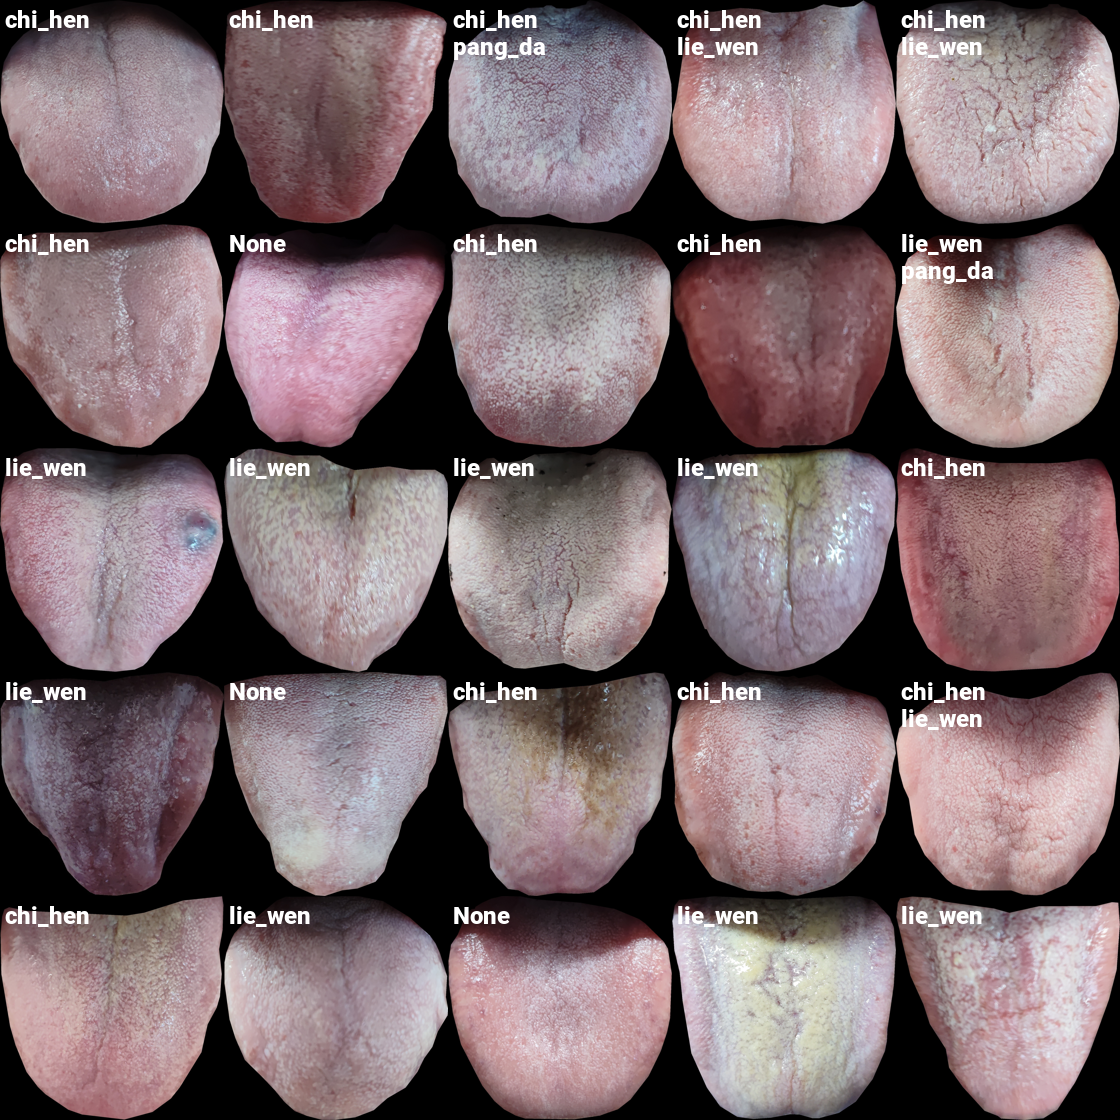

In [2]:
from PIL import Image, ImageDraw, ImageFont


def show_multi_label_examples(image_paths, labels, classes, n: int, m: int, size=(224, 224)):
    w, h = size
    num_classes = len(classes)

    # 计算每行显示的示例数量
    examples_per_row = m
    # 计算显示示例的行数
    num_rows = n
    # 计算网格图像的大小
    grid_size = (examples_per_row * w, num_rows * h)

    grid = Image.new('RGB', size=grid_size, color=(255, 255, 255))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("C:\\Users\\ChenXi\\fonts\\Roboto\\Roboto-Black.ttf", 24)

    for row in range(num_rows):
        for col in range(examples_per_row):
            idx = row * examples_per_row + col

            # 获取图片路径和对应的标签
            img_path = image_paths[idx]
            img_label = labels[idx]

            # 读取图片
            image = Image.open(img_path)

            # 读取图像的 Exif 信息，获取方向信息
            exif = image._getexif()
            orientation = exif.get(0x0112, 1) if exif else 1

            # 根据方向信息旋转图像
            if orientation == 1:
                pass
            elif orientation == 3:
                image = image.rotate(180, expand=True)
            elif orientation == 6:
                image = image.rotate(270, expand=True)
            elif orientation == 8:
                image = image.rotate(90, expand=True)

            image = image.resize(size)

            # 绘制图片
            box = (col * w, row * h)
            grid.paste(image, box=box)

            # 读取图片的标签
            label_indices = img_label
            labels_text = [classes[i] for i in range(num_classes) if label_indices[i] == 1]
            label_text = '\n'.join(labels_text) if labels_text else 'None'

            # 在图片左上角写标签
            draw.text((box[0] + 5, box[1] + 5), label_text, (255, 255, 255), font=font)

    return grid


show_multi_label_examples(image_paths, labels, classes, n=5, m=5)

In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms


class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


# 数据预处理和转换
dataset_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 创建数据集
dataset = MultiLabelDataset(image_paths, labels)

# 创建数据加载器
batch_size = len(dataset)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
dataloader.dataset.transform = dataset_transform
# 获取所有图像数据
all_images = None

for inputs, _ in dataloader:
    all_images = inputs

# 计算数据集的均值和标准差
mean = torch.mean(all_images, dim=(0, 2, 3))
std = torch.std(all_images, dim=(0, 2, 3))

print(f"均值：{mean}")
print(f"标准差：{std}")

均值：tensor([0.4816, 0.4065, 0.4196])
标准差：tensor([0.2920, 0.2612, 0.2687])


In [4]:
from torch.utils.data import random_split
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import TensorDataset


class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0

        mask = torch.from_numpy(mask)
        img *= mask.unsqueeze(0)

        return img
    

def binary_to_int(binary_label):
    """
    将二进制序列标签转换为一个整数

    Args:
    binary_label (np.ndarray): 二进制序列标签数组

    Returns:
    int: 转换后的整数
    """
    return int(''.join(map(str, binary_label)), 2)

def int_to_binary(number, num_bits):
    """
    将一个整数转换为对应位数的二进制序列标签

    Args:
    number (int): 要转换的整数
    num_bits (int): 二进制序列标签的位数

    Returns:
    np.ndarray: 转换后的二进制序列标签数组
    """
    binary_label = bin(number)[2:].zfill(num_bits)
    return np.array([int(bit) for bit in binary_label])


# 数据增强和预处理
data_augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomApply(transforms.GaussianBlur(3, sigma=(0.1, 2.0)), 0.5),
    Cutout(n_holes=8, length=32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# 划分数据集
train_size = int(4 / 6.0 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 划分数据集
# train_size = int(4 / 6.0 * len(dataset))
# val_size = int(1 / 6.0 * len(dataset))
# test_size = len(dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# 获取训练集的特征和标签
X_train = []
y_train = []
for inputs, labels in train_dataset:
    X_train.append(inputs.numpy())  # 将张量转换为 numpy 数组
    y_train.append(labels)
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape, y_train.shape, len(X_train))

# 将标签转换为二进制形式
binary_labels = np.array([binary_to_int(label) for label in y_train])
# print(binary_labels)

# 创建 RandomOverSampler 实例
ros = RandomOverSampler(random_state=seed)

# 进行过采样
X_resampled, y_resampled = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), binary_labels)

# 将特征转换回张量形式
X_resampled = torch.tensor(X_resampled.reshape(-1, *inputs.shape))
y_resampled = np.array([int_to_binary(label, len(classes)) for label in y_resampled])
print("过采样后的训练集特征形状：", X_resampled.shape)
print("过采样后的训练集标签形状：", y_resampled.shape)
# print(y_resampled)

# 创建过采样后的训练集
oversampled_train_dataset = TensorDataset(X_resampled, torch.tensor(y_resampled))

(60, 3, 224, 224) (60, 3) 60
过采样后的训练集特征形状： torch.Size([132, 3, 224, 224])
过采样后的训练集标签形状： (132, 3)


In [5]:
trainloader = DataLoader(oversampled_train_dataset, batch_size=8, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
# testloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

trainloader.dataset.transform = data_augmentation_transform
valloader.dataset.transform = transform
# testloader.dataset.transform = transform

## 定义网络结构

In [6]:
import torch.nn as nn
from transformers import ViTImageProcessor, ViTModel


class VisionTransformerForMultiLabelClassification(nn.Module):
    def __init__(self, num_labels, model_name='google/vit-base-patch16-224-in21k'):
        super(VisionTransformerForMultiLabelClassification, self).__init__()
        self.vit = ViTModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        output = self.vit(images)
        output = self.classifier(output.pooler_output)
        output = self.sigmoid(output)
        return output
    

model_name = 'google/vit-base-patch16-224-in21k'
image_processor = ViTImageProcessor.from_pretrained(
    model_name,
    do_normalize=False,
    do_resize=False,
    do_rescale=False,
    )

In [7]:
import torch.optim as optim
from tqdm import tqdm
import optuna
import json
import shutil


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义损失函数和优化器
criterion = nn.BCELoss()  # 二分类交叉熵损失


def objective(trial):
    # 定义超参数搜索空间
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)  # 学习率
    weight_decay = trial.suggest_float(
        'weight_decay', 1e-4, 1e-1, log=True)  # 权重衰减
    num_epochs = trial.suggest_int('num_epochs', 10, 20)  # 迭代轮数
    batch_size = trial.suggest_int('batch_size', 8, 32)  # 批量大小

    # 创建超参数字典
    hyperparameters = {
        'lr': lr,
        'weight_decay': weight_decay,
        'num_epochs': num_epochs,
        'batch_size': batch_size
    }

    trainloader = DataLoader(oversampled_train_dataset,
                             batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    trainloader.dataset.transform = data_augmentation_transform
    valloader.dataset.transform = transform

    # 创建模型和优化器
    model = VisionTransformerForMultiLabelClassification(
        num_labels=len(classes))
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr,
                           weight_decay=weight_decay)
    best_val_loss = float('inf')

    # 创建当前试验的文件夹
    trial_folder = f'./tongue-disease-classification/tongue_shape/trial_{trial.number}'
    if not os.path.exists(trial_folder):
        os.makedirs(trial_folder)
    with open(os.path.join(trial_folder, 'hyperparameters.json'), 'w') as f:
        json.dump(hyperparameters, f)

    # 训练模型
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_running_loss = 0.0
        for inputs, labels in trainloader:
            inputs = image_processor(
                images=inputs, return_tensors="pt").pixel_values
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())  # 将标签转换为 float 类型
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()

        # 验证模型
        model.eval()
        correct = 0
        total = 0
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predicted = torch.round(outputs)  # 四舍五入到最近的整数，作为预测
                loss = criterion(outputs, labels.float())
                total += labels.numel()
                correct += (predicted == labels).sum().item()
                val_running_loss += loss.item()

        # 输出验证集的准确率
        accuracy = correct / total

        # 训练集损失
        train_running_loss /= len(trainloader)
        # 验证集损失
        val_running_loss /= len(valloader)

        # 输出每个epoch的平均损失
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_running_loss}, Val Loss: {val_running_loss}, Val Accuracy: {accuracy}")

        # 更新 Optuna 的试验对象
        trial.report(val_running_loss, epoch)

        # 提前停止
        if trial.should_prune():
            shutil.rmtree(trial_folder)
            raise optuna.TrialPruned()

        # 如果当前模型的验证损失更好，则保存模型
        if epoch > 5 and val_running_loss < best_val_loss:
            best_val_loss = val_running_loss
            model_path = os.path.join(trial_folder, f'best_model.pth')
            torch.save(model.state_dict(), model_path)

    # 返回验证损失作为目标函数的结果
    return best_val_loss


# 创建 Optuna 试验
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2024-05-08 12:36:39,877] A new study created in memory with name: no-name-5fa04fc8-c95a-4d69-9d2a-e7023ddd748b
  8%|▊         | 1/13 [00:09<01:53,  9.45s/it]

Epoch 1/13, Train Loss: 0.6248539566993714, Val Loss: 0.6934676468372345, Val Accuracy: 0.6236559139784946


 15%|█▌        | 2/13 [00:18<01:43,  9.39s/it]

Epoch 2/13, Train Loss: 0.5293907463550568, Val Loss: 0.7045172452926636, Val Accuracy: 0.6344086021505376


 23%|██▎       | 3/13 [00:28<01:33,  9.32s/it]

Epoch 3/13, Train Loss: 0.465429949760437, Val Loss: 0.7153399288654327, Val Accuracy: 0.6129032258064516


 31%|███       | 4/13 [00:37<01:23,  9.27s/it]

Epoch 4/13, Train Loss: 0.40935527682304385, Val Loss: 0.7219623625278473, Val Accuracy: 0.6451612903225806


 38%|███▊      | 5/13 [00:46<01:13,  9.25s/it]

Epoch 5/13, Train Loss: 0.365048885345459, Val Loss: 0.7279516458511353, Val Accuracy: 0.6666666666666666


 46%|████▌     | 6/13 [00:55<01:04,  9.24s/it]

Epoch 6/13, Train Loss: 0.324092835187912, Val Loss: 0.7380578815937042, Val Accuracy: 0.6774193548387096
Epoch 7/13, Train Loss: 0.28773356676101686, Val Loss: 0.7513829469680786, Val Accuracy: 0.6559139784946236


 62%|██████▏   | 8/13 [01:14<00:45,  9.19s/it]

Epoch 8/13, Train Loss: 0.2561951994895935, Val Loss: 0.7557851672172546, Val Accuracy: 0.6451612903225806


 69%|██████▉   | 9/13 [01:23<00:36,  9.15s/it]

Epoch 9/13, Train Loss: 0.228800493478775, Val Loss: 0.7586593925952911, Val Accuracy: 0.6881720430107527


 77%|███████▋  | 10/13 [01:32<00:27,  9.12s/it]

Epoch 10/13, Train Loss: 0.204499289393425, Val Loss: 0.7696683704853058, Val Accuracy: 0.6881720430107527


 85%|████████▍ | 11/13 [01:41<00:18,  9.11s/it]

Epoch 11/13, Train Loss: 0.1840512454509735, Val Loss: 0.7673311084508896, Val Accuracy: 0.7096774193548387


 92%|█████████▏| 12/13 [01:50<00:09,  9.09s/it]

Epoch 12/13, Train Loss: 0.16591705679893493, Val Loss: 0.7790859788656235, Val Accuracy: 0.7204301075268817


100%|██████████| 13/13 [01:59<00:00,  9.18s/it]
[I 2024-05-08 12:38:40,031] Trial 0 finished with value: 0.7513829469680786 and parameters: {'lr': 1.5573569048182254e-05, 'weight_decay': 0.00010465434458778711, 'num_epochs': 13, 'batch_size': 28}. Best is trial 0 with value: 0.7513829469680786.


Epoch 13/13, Train Loss: 0.15001696348190308, Val Loss: 0.7819392830133438, Val Accuracy: 0.7311827956989247


  7%|▋         | 1/14 [00:06<01:24,  6.51s/it]

Epoch 1/14, Train Loss: 0.621388566493988, Val Loss: 0.8072771430015564, Val Accuracy: 0.6451612903225806


 14%|█▍        | 2/14 [00:12<01:16,  6.34s/it]

Epoch 2/14, Train Loss: 0.5749492883682251, Val Loss: 0.7656438946723938, Val Accuracy: 0.6774193548387096


 21%|██▏       | 3/14 [00:18<01:09,  6.28s/it]

Epoch 3/14, Train Loss: 0.6684671640396118, Val Loss: 0.810643196105957, Val Accuracy: 0.6236559139784946


 29%|██▊       | 4/14 [00:25<01:02,  6.27s/it]

Epoch 4/14, Train Loss: 0.66052166223526, Val Loss: 0.787903368473053, Val Accuracy: 0.5913978494623656


 36%|███▌      | 5/14 [00:31<00:56,  6.29s/it]

Epoch 5/14, Train Loss: 0.6524690628051758, Val Loss: 0.7848005294799805, Val Accuracy: 0.6451612903225806


 43%|████▎     | 6/14 [00:37<00:50,  6.30s/it]

Epoch 6/14, Train Loss: 0.6620960474014282, Val Loss: 0.7865372896194458, Val Accuracy: 0.5376344086021505
Epoch 7/14, Train Loss: 0.6786488056182861, Val Loss: 0.7672421932220459, Val Accuracy: 0.5913978494623656


 57%|█████▋    | 8/14 [00:50<00:38,  6.34s/it]

Epoch 8/14, Train Loss: 0.6757006525993348, Val Loss: 0.8034419417381287, Val Accuracy: 0.6451612903225806


 64%|██████▍   | 9/14 [00:56<00:31,  6.29s/it]

Epoch 9/14, Train Loss: 0.6581434607505798, Val Loss: 0.8091716468334198, Val Accuracy: 0.6451612903225806


 71%|███████▏  | 10/14 [01:02<00:25,  6.26s/it]

Epoch 10/14, Train Loss: 0.6620734572410584, Val Loss: 0.7895298004150391, Val Accuracy: 0.5913978494623656


 79%|███████▊  | 11/14 [01:09<00:18,  6.23s/it]

Epoch 11/14, Train Loss: 0.6680901288986206, Val Loss: 0.8143607378005981, Val Accuracy: 0.5913978494623656


 86%|████████▌ | 12/14 [01:15<00:12,  6.25s/it]

Epoch 12/14, Train Loss: 0.6613973021507263, Val Loss: 0.78154057264328, Val Accuracy: 0.6451612903225806


 93%|█████████▎| 13/14 [01:21<00:06,  6.27s/it]

Epoch 13/14, Train Loss: 0.6547357678413391, Val Loss: 0.7761619985103607, Val Accuracy: 0.6451612903225806


100%|██████████| 14/14 [01:28<00:00,  6.29s/it]
[I 2024-05-08 12:40:08,945] Trial 1 finished with value: 0.7672421932220459 and parameters: {'lr': 0.001168443080615198, 'weight_decay': 0.031001149488055265, 'num_epochs': 14, 'batch_size': 30}. Best is trial 0 with value: 0.7513829469680786.


Epoch 14/14, Train Loss: 0.6629906535148621, Val Loss: 0.8111316561698914, Val Accuracy: 0.5913978494623656


  5%|▌         | 1/19 [00:08<02:38,  8.78s/it]

Epoch 1/19, Train Loss: 0.5962846080462137, Val Loss: 0.6757753491401672, Val Accuracy: 0.6666666666666666


 11%|█         | 2/19 [00:18<02:42,  9.56s/it]

Epoch 2/19, Train Loss: 0.3523886650800705, Val Loss: 0.724703460931778, Val Accuracy: 0.7419354838709677


 16%|█▌        | 3/19 [00:28<02:36,  9.78s/it]

Epoch 3/19, Train Loss: 0.23951730380455652, Val Loss: 0.86721470952034, Val Accuracy: 0.6881720430107527


 21%|██        | 4/19 [00:39<02:28,  9.91s/it]

Epoch 4/19, Train Loss: 0.19603816171487173, Val Loss: 0.829684317111969, Val Accuracy: 0.6989247311827957


 26%|██▋       | 5/19 [00:48<02:18,  9.92s/it]

Epoch 5/19, Train Loss: 0.1966829150915146, Val Loss: 0.8389070928096771, Val Accuracy: 0.7204301075268817


 32%|███▏      | 6/19 [00:58<02:08,  9.92s/it]

Epoch 6/19, Train Loss: 0.14132219552993774, Val Loss: 0.8008325099945068, Val Accuracy: 0.7311827956989247
Epoch 7/19, Train Loss: 0.07519022809962432, Val Loss: 0.9300010055303574, Val Accuracy: 0.7419354838709677


 42%|████▏     | 8/19 [01:19<01:50, 10.02s/it]

Epoch 8/19, Train Loss: 0.049683679516116776, Val Loss: 1.2481431066989899, Val Accuracy: 0.6451612903225806


 47%|████▋     | 9/19 [01:29<01:39, 10.00s/it]

Epoch 9/19, Train Loss: 0.03333477055033048, Val Loss: 1.1132963001728058, Val Accuracy: 0.7311827956989247


 53%|█████▎    | 10/19 [01:39<01:29,  9.98s/it]

Epoch 10/19, Train Loss: 0.026549017056822777, Val Loss: 1.1991038918495178, Val Accuracy: 0.7096774193548387


 58%|█████▊    | 11/19 [01:49<01:19,  9.99s/it]

Epoch 11/19, Train Loss: 0.025176475755870342, Val Loss: 1.2039660811424255, Val Accuracy: 0.7096774193548387


 63%|██████▎   | 12/19 [01:59<01:10, 10.04s/it]

Epoch 12/19, Train Loss: 0.02219199265042941, Val Loss: 1.1328264474868774, Val Accuracy: 0.7204301075268817


 68%|██████▊   | 13/19 [02:09<01:00, 10.04s/it]

Epoch 13/19, Train Loss: 0.01559162155414621, Val Loss: 1.2174744606018066, Val Accuracy: 0.7204301075268817


 74%|███████▎  | 14/19 [02:19<00:50, 10.01s/it]

Epoch 14/19, Train Loss: 0.014184374051789442, Val Loss: 1.1925975382328033, Val Accuracy: 0.7204301075268817


 79%|███████▉  | 15/19 [02:29<00:39,  9.99s/it]

Epoch 15/19, Train Loss: 0.012058707575003305, Val Loss: 1.2981452345848083, Val Accuracy: 0.7096774193548387


 84%|████████▍ | 16/19 [02:39<00:30, 10.00s/it]

Epoch 16/19, Train Loss: 0.011273358793308338, Val Loss: 1.2885433435440063, Val Accuracy: 0.7096774193548387


 89%|████████▉ | 17/19 [02:49<00:20, 10.03s/it]

Epoch 17/19, Train Loss: 0.010606729115049044, Val Loss: 1.261970341205597, Val Accuracy: 0.7204301075268817


 95%|█████████▍| 18/19 [02:59<00:10, 10.05s/it]

Epoch 18/19, Train Loss: 0.010127199192841848, Val Loss: 1.275847166776657, Val Accuracy: 0.7096774193548387


100%|██████████| 19/19 [03:09<00:00,  9.98s/it]
[I 2024-05-08 12:43:19,284] Trial 2 finished with value: 0.9300010055303574 and parameters: {'lr': 0.00021743737046461646, 'weight_decay': 0.0012456720634017454, 'num_epochs': 19, 'batch_size': 25}. Best is trial 0 with value: 0.7513829469680786.


Epoch 19/19, Train Loss: 0.009957305310914913, Val Loss: 1.26687952876091, Val Accuracy: 0.6989247311827957


 10%|█         | 1/10 [00:03<00:29,  3.31s/it]

Epoch 1/10, Train Loss: 0.6634883540017265, Val Loss: 0.6568731069564819, Val Accuracy: 0.6451612903225806


 20%|██        | 2/10 [00:06<00:25,  3.24s/it]

Epoch 2/10, Train Loss: 0.5462391631943839, Val Loss: 0.6307588219642639, Val Accuracy: 0.6129032258064516


 30%|███       | 3/10 [00:09<00:22,  3.22s/it]

Epoch 3/10, Train Loss: 0.47685305561338154, Val Loss: 0.6178954243659973, Val Accuracy: 0.6236559139784946


 40%|████      | 4/10 [00:12<00:19,  3.20s/it]

Epoch 4/10, Train Loss: 0.4234913630144937, Val Loss: 0.6099834740161896, Val Accuracy: 0.6236559139784946


 50%|█████     | 5/10 [00:16<00:15,  3.20s/it]

Epoch 5/10, Train Loss: 0.3782658576965332, Val Loss: 0.6033473908901215, Val Accuracy: 0.6129032258064516


 60%|██████    | 6/10 [00:19<00:12,  3.20s/it]

Epoch 6/10, Train Loss: 0.3406128627913339, Val Loss: 0.5990175008773804, Val Accuracy: 0.6236559139784946
Epoch 7/10, Train Loss: 0.30229975070272175, Val Loss: 0.5944567024707794, Val Accuracy: 0.6559139784946236


 70%|███████   | 7/10 [00:22<00:09,  3.30s/it]

Epoch 8/10, Train Loss: 0.2721653027193887, Val Loss: 0.5927035212516785, Val Accuracy: 0.6666666666666666


 80%|████████  | 8/10 [00:26<00:06,  3.36s/it]

Epoch 9/10, Train Loss: 0.24631753351007188, Val Loss: 0.5898681879043579, Val Accuracy: 0.6774193548387096


 90%|█████████ | 9/10 [00:29<00:03,  3.40s/it]

Epoch 10/10, Train Loss: 0.22236238632883346, Val Loss: 0.5883567631244659, Val Accuracy: 0.6774193548387096


100%|██████████| 10/10 [00:33<00:00,  3.32s/it]
[I 2024-05-08 12:43:53,467] Trial 3 finished with value: 0.5883567631244659 and parameters: {'lr': 1.1963163926243131e-05, 'weight_decay': 0.00036739532896084767, 'num_epochs': 10, 'batch_size': 20}. Best is trial 3 with value: 0.5883567631244659.
  7%|▋         | 1/15 [00:16<03:51, 16.53s/it]

Epoch 1/15, Train Loss: 0.672045361995697, Val Loss: 0.6152461171150208, Val Accuracy: 0.6021505376344086


 13%|█▎        | 2/15 [00:32<03:32, 16.38s/it]

Epoch 2/15, Train Loss: 0.6646163463592529, Val Loss: 0.6746302843093872, Val Accuracy: 0.6344086021505376


 20%|██        | 3/15 [00:49<03:16, 16.41s/it]

Epoch 3/15, Train Loss: 0.651080310344696, Val Loss: 0.6781302690505981, Val Accuracy: 0.5913978494623656


 27%|██▋       | 4/15 [01:05<02:59, 16.35s/it]

Epoch 4/15, Train Loss: 0.6794160604476929, Val Loss: 0.6783591508865356, Val Accuracy: 0.5913978494623656


 33%|███▎      | 5/15 [01:21<02:43, 16.32s/it]

Epoch 5/15, Train Loss: 0.6589597582817077, Val Loss: 0.6423848271369934, Val Accuracy: 0.5913978494623656


 40%|████      | 6/15 [01:37<02:26, 16.24s/it]

Epoch 6/15, Train Loss: 0.6640611410140991, Val Loss: 0.6411842107772827, Val Accuracy: 0.5913978494623656
Epoch 7/15, Train Loss: 0.6593844294548035, Val Loss: 0.6409921050071716, Val Accuracy: 0.6451612903225806


 53%|█████▎    | 8/15 [02:10<01:52, 16.14s/it]

Epoch 8/15, Train Loss: 0.6607724547386169, Val Loss: 0.6491554975509644, Val Accuracy: 0.6451612903225806


 60%|██████    | 9/15 [02:26<01:36, 16.10s/it]

Epoch 9/15, Train Loss: 0.6542373657226562, Val Loss: 0.6714648008346558, Val Accuracy: 0.6451612903225806


 67%|██████▋   | 10/15 [02:42<01:21, 16.20s/it]

Epoch 10/15, Train Loss: 0.6525490880012512, Val Loss: 0.677837610244751, Val Accuracy: 0.6451612903225806


 73%|███████▎  | 11/15 [02:58<01:05, 16.26s/it]

Epoch 11/15, Train Loss: 0.6798341870307922, Val Loss: 0.6651813387870789, Val Accuracy: 0.6451612903225806


 80%|████████  | 12/15 [03:14<00:48, 16.20s/it]

Epoch 12/15, Train Loss: 0.6630127906799317, Val Loss: 0.6704789996147156, Val Accuracy: 0.6451612903225806


 87%|████████▋ | 13/15 [03:31<00:32, 16.18s/it]

Epoch 13/15, Train Loss: 0.6651286244392395, Val Loss: 0.6661765575408936, Val Accuracy: 0.5913978494623656


 93%|█████████▎| 14/15 [03:47<00:16, 16.13s/it]

Epoch 14/15, Train Loss: 0.6655076622962952, Val Loss: 0.6626306772232056, Val Accuracy: 0.5913978494623656


100%|██████████| 15/15 [04:02<00:00, 16.20s/it]
[I 2024-05-08 12:47:57,222] Trial 4 finished with value: 0.6409921050071716 and parameters: {'lr': 0.0035535939068611637, 'weight_decay': 0.07315575482334608, 'num_epochs': 15, 'batch_size': 32}. Best is trial 3 with value: 0.5883567631244659.


Epoch 15/15, Train Loss: 0.6621636152267456, Val Loss: 0.6571078300476074, Val Accuracy: 0.5913978494623656


  9%|▉         | 1/11 [00:16<02:41, 16.13s/it]

Epoch 1/11, Train Loss: 0.6131592869758606, Val Loss: 0.5897083282470703, Val Accuracy: 0.7096774193548387


 18%|█▊        | 2/11 [00:32<02:25, 16.21s/it]

Epoch 2/11, Train Loss: 0.44321984648704527, Val Loss: 0.5586669445037842, Val Accuracy: 0.7096774193548387


 27%|██▋       | 3/11 [00:48<02:09, 16.15s/it]

Epoch 3/11, Train Loss: 0.34725874066352846, Val Loss: 0.5597476959228516, Val Accuracy: 0.6989247311827957


 36%|███▋      | 4/11 [01:04<01:52, 16.07s/it]

Epoch 4/11, Train Loss: 0.2860592246055603, Val Loss: 0.5558428168296814, Val Accuracy: 0.7311827956989247


 45%|████▌     | 5/11 [01:20<01:36, 16.04s/it]

Epoch 5/11, Train Loss: 0.23560514748096467, Val Loss: 0.5659816265106201, Val Accuracy: 0.6774193548387096


 55%|█████▍    | 6/11 [01:36<01:20, 16.17s/it]

Epoch 6/11, Train Loss: 0.1932366281747818, Val Loss: 0.5577338337898254, Val Accuracy: 0.7096774193548387
Epoch 7/11, Train Loss: 0.15993907451629638, Val Loss: 0.5547679662704468, Val Accuracy: 0.6774193548387096


 73%|███████▎  | 8/11 [02:09<00:48, 16.11s/it]

Epoch 8/11, Train Loss: 0.12821150571107864, Val Loss: 0.5586645007133484, Val Accuracy: 0.7096774193548387


 82%|████████▏ | 9/11 [02:24<00:32, 16.03s/it]

Epoch 9/11, Train Loss: 0.09950996190309525, Val Loss: 0.560952365398407, Val Accuracy: 0.6989247311827957


 91%|█████████ | 10/11 [02:40<00:15, 15.99s/it]

Epoch 10/11, Train Loss: 0.08058209866285324, Val Loss: 0.5901434421539307, Val Accuracy: 0.7204301075268817


100%|██████████| 11/11 [02:56<00:00, 16.07s/it]
[I 2024-05-08 12:50:58,153] Trial 5 finished with value: 0.5547679662704468 and parameters: {'lr': 5.359398687330774e-05, 'weight_decay': 0.00016827794413498554, 'num_epochs': 11, 'batch_size': 32}. Best is trial 5 with value: 0.5547679662704468.


Epoch 11/11, Train Loss: 0.06666405126452446, Val Loss: 0.6155037879943848, Val Accuracy: 0.7204301075268817


  7%|▋         | 1/14 [00:04<00:57,  4.43s/it]

Epoch 1/14, Train Loss: 0.7349785193800926, Val Loss: 0.6218396425247192, Val Accuracy: 0.6451612903225806


 14%|█▍        | 2/14 [00:08<00:52,  4.42s/it]

Epoch 2/14, Train Loss: 0.6768829077482224, Val Loss: 0.659370481967926, Val Accuracy: 0.5913978494623656


 21%|██▏       | 3/14 [00:13<00:48,  4.41s/it]

Epoch 3/14, Train Loss: 0.6703390702605247, Val Loss: 0.6830065548419952, Val Accuracy: 0.5913978494623656


 29%|██▊       | 4/14 [00:17<00:44,  4.41s/it]

Epoch 4/14, Train Loss: 0.6598527058959007, Val Loss: 0.6353341042995453, Val Accuracy: 0.6451612903225806


 36%|███▌      | 5/14 [00:22<00:39,  4.41s/it]

Epoch 5/14, Train Loss: 0.6568926945328712, Val Loss: 0.6498189866542816, Val Accuracy: 0.6451612903225806


 43%|████▎     | 6/14 [00:26<00:35,  4.41s/it]

Epoch 6/14, Train Loss: 0.6524026021361351, Val Loss: 0.6437137722969055, Val Accuracy: 0.5913978494623656
Epoch 7/14, Train Loss: 0.6570594385266304, Val Loss: 0.649399608373642, Val Accuracy: 0.5913978494623656


 50%|█████     | 7/14 [00:31<00:31,  4.48s/it]

Epoch 8/14, Train Loss: 0.6624566316604614, Val Loss: 0.646257221698761, Val Accuracy: 0.5913978494623656


 64%|██████▍   | 9/14 [00:40<00:22,  4.50s/it]

Epoch 9/14, Train Loss: 0.6568085625767708, Val Loss: 0.6527329087257385, Val Accuracy: 0.6451612903225806


 71%|███████▏  | 10/14 [00:44<00:17,  4.47s/it]

Epoch 10/14, Train Loss: 0.6614104956388474, Val Loss: 0.6640063226222992, Val Accuracy: 0.6451612903225806


 79%|███████▊  | 11/14 [00:48<00:13,  4.46s/it]

Epoch 11/14, Train Loss: 0.6514334604144096, Val Loss: 0.6549184918403625, Val Accuracy: 0.5913978494623656


 86%|████████▌ | 12/14 [00:53<00:08,  4.46s/it]

Epoch 12/14, Train Loss: 0.6623243391513824, Val Loss: 0.6538327932357788, Val Accuracy: 0.5913978494623656


 93%|█████████▎| 13/14 [00:57<00:04,  4.47s/it]

Epoch 13/14, Train Loss: 0.6632830202579498, Val Loss: 0.6541461646556854, Val Accuracy: 0.5913978494623656


100%|██████████| 14/14 [01:02<00:00,  4.46s/it]
[I 2024-05-08 12:52:01,310] Trial 6 finished with value: 0.646257221698761 and parameters: {'lr': 0.004594423000736279, 'weight_decay': 0.009289791657367317, 'num_epochs': 14, 'batch_size': 18}. Best is trial 5 with value: 0.5547679662704468.


Epoch 14/14, Train Loss: 0.6611593067646027, Val Loss: 0.6521593034267426, Val Accuracy: 0.5913978494623656


  7%|▋         | 1/15 [00:15<03:43, 15.97s/it]

Epoch 1/15, Train Loss: 0.6054796934127807, Val Loss: 0.6211965680122375, Val Accuracy: 0.6666666666666666


 13%|█▎        | 2/15 [00:31<03:26, 15.90s/it]

Epoch 2/15, Train Loss: 0.4246279299259186, Val Loss: 0.5732343792915344, Val Accuracy: 0.6881720430107527


 20%|██        | 3/15 [00:47<03:11, 15.96s/it]

Epoch 3/15, Train Loss: 0.2958251118659973, Val Loss: 0.6144540309906006, Val Accuracy: 0.6774193548387096


 27%|██▋       | 4/15 [01:04<02:56, 16.09s/it]

Epoch 4/15, Train Loss: 0.2716111332178116, Val Loss: 0.5933111310005188, Val Accuracy: 0.7204301075268817


 33%|███▎      | 5/15 [01:20<02:41, 16.13s/it]

Epoch 5/15, Train Loss: 0.2075548380613327, Val Loss: 0.6931599974632263, Val Accuracy: 0.6666666666666666


 40%|████      | 6/15 [01:36<02:25, 16.13s/it]

Epoch 6/15, Train Loss: 0.1751488208770752, Val Loss: 0.7570288181304932, Val Accuracy: 0.6666666666666666
Epoch 7/15, Train Loss: 0.11595704257488251, Val Loss: 0.7882470488548279, Val Accuracy: 0.6881720430107527


 53%|█████▎    | 8/15 [02:08<01:53, 16.15s/it]

Epoch 8/15, Train Loss: 0.10526139438152313, Val Loss: 0.8987715244293213, Val Accuracy: 0.6881720430107527


 60%|██████    | 9/15 [02:24<01:36, 16.09s/it]

Epoch 9/15, Train Loss: 0.08219842538237572, Val Loss: 0.9724352359771729, Val Accuracy: 0.6344086021505376


 67%|██████▋   | 10/15 [02:40<01:20, 16.05s/it]

Epoch 10/15, Train Loss: 0.06010298430919647, Val Loss: 1.0418392419815063, Val Accuracy: 0.6881720430107527


 73%|███████▎  | 11/15 [02:56<01:04, 16.01s/it]

Epoch 11/15, Train Loss: 0.056927147507667544, Val Loss: 1.0748887062072754, Val Accuracy: 0.6451612903225806


 80%|████████  | 12/15 [03:12<00:47, 15.99s/it]

Epoch 12/15, Train Loss: 0.03913096971809864, Val Loss: 1.0378745794296265, Val Accuracy: 0.6774193548387096


 87%|████████▋ | 13/15 [03:28<00:31, 15.99s/it]

Epoch 13/15, Train Loss: 0.02750359885394573, Val Loss: 1.0721561908721924, Val Accuracy: 0.6666666666666666


 93%|█████████▎| 14/15 [03:44<00:15, 15.95s/it]

Epoch 14/15, Train Loss: 0.018604125082492828, Val Loss: 1.0828102827072144, Val Accuracy: 0.6989247311827957


100%|██████████| 15/15 [04:00<00:00, 16.03s/it]
[I 2024-05-08 12:56:02,533] Trial 7 finished with value: 0.7882470488548279 and parameters: {'lr': 0.00026542094439292176, 'weight_decay': 0.0009015568278623589, 'num_epochs': 15, 'batch_size': 32}. Best is trial 5 with value: 0.5547679662704468.


Epoch 15/15, Train Loss: 0.01469108574092388, Val Loss: 1.1014940738677979, Val Accuracy: 0.6774193548387096


  0%|          | 0/12 [00:04<?, ?it/s]
[I 2024-05-08 12:56:09,412] Trial 8 pruned. 


Epoch 1/12, Train Loss: 0.6727699703640408, Val Loss: 0.6565625667572021, Val Accuracy: 0.6451612903225806


  0%|          | 0/11 [00:04<?, ?it/s]
[I 2024-05-08 12:56:14,676] Trial 9 pruned. 


Epoch 1/11, Train Loss: 0.6568159858385721, Val Loss: 0.7210804422696432, Val Accuracy: 0.6129032258064516


  0%|          | 0/18 [00:02<?, ?it/s]
[I 2024-05-08 12:56:18,326] Trial 10 pruned. 


Epoch 1/18, Train Loss: 0.5292728160108838, Val Loss: 0.7200873494148254, Val Accuracy: 0.5913978494623656


  0%|          | 0/10 [00:07<?, ?it/s]
[I 2024-05-08 12:56:26,255] Trial 11 pruned. 


Epoch 1/10, Train Loss: 0.6435214479764303, Val Loss: 0.6662740111351013, Val Accuracy: 0.6881720430107527


 10%|█         | 1/10 [00:05<00:51,  5.69s/it]

Epoch 1/10, Train Loss: 0.6124429447310311, Val Loss: 0.6260428726673126, Val Accuracy: 0.6129032258064516


 20%|██        | 2/10 [00:11<00:46,  5.87s/it]

Epoch 2/10, Train Loss: 0.4427820018359593, Val Loss: 0.6182007193565369, Val Accuracy: 0.6021505376344086


 30%|███       | 3/10 [00:17<00:41,  5.92s/it]

Epoch 3/10, Train Loss: 0.33254229596682955, Val Loss: 0.6049933433532715, Val Accuracy: 0.7096774193548387


 40%|████      | 4/10 [00:23<00:35,  5.95s/it]

Epoch 4/10, Train Loss: 0.264568282025201, Val Loss: 0.6022685468196869, Val Accuracy: 0.7096774193548387


 50%|█████     | 5/10 [00:29<00:29,  5.97s/it]

Epoch 5/10, Train Loss: 0.20321747022015707, Val Loss: 0.5927425771951675, Val Accuracy: 0.7096774193548387


 60%|██████    | 6/10 [00:35<00:23,  5.98s/it]

Epoch 6/10, Train Loss: 0.15142636852605001, Val Loss: 0.6293790936470032, Val Accuracy: 0.6989247311827957
Epoch 7/10, Train Loss: 0.11913471349648067, Val Loss: 0.591743215918541, Val Accuracy: 0.7526881720430108


 80%|████████  | 8/10 [00:48<00:12,  6.09s/it]

Epoch 8/10, Train Loss: 0.09281292877026967, Val Loss: 0.6374566704034805, Val Accuracy: 0.7419354838709677


 90%|█████████ | 9/10 [00:54<00:06,  6.09s/it]

Epoch 9/10, Train Loss: 0.07612659462860652, Val Loss: 0.6391289830207825, Val Accuracy: 0.7526881720430108


100%|██████████| 10/10 [01:00<00:00,  6.03s/it]
[I 2024-05-08 12:57:27,337] Trial 12 finished with value: 0.591743215918541 and parameters: {'lr': 4.0313656640845985e-05, 'weight_decay': 0.00037869360148845636, 'num_epochs': 10, 'batch_size': 21}. Best is trial 5 with value: 0.5547679662704468.


Epoch 10/10, Train Loss: 0.06133878550359181, Val Loss: 0.6685495376586914, Val Accuracy: 0.6989247311827957


  0%|          | 0/17 [00:13<?, ?it/s]
[I 2024-05-08 12:57:41,390] Trial 13 pruned. 


Epoch 1/17, Train Loss: 0.6088723142941793, Val Loss: 0.6840345561504364, Val Accuracy: 0.6021505376344086


  8%|▊         | 1/12 [00:02<00:30,  2.78s/it]

Epoch 1/12, Train Loss: 0.5608893260359764, Val Loss: 0.5774117509524027, Val Accuracy: 0.7204301075268817


 17%|█▋        | 2/12 [00:05<00:27,  2.79s/it]

Epoch 2/12, Train Loss: 0.31696393092473346, Val Loss: 0.5727236270904541, Val Accuracy: 0.7741935483870968


 25%|██▌       | 3/12 [00:08<00:25,  2.80s/it]

Epoch 3/12, Train Loss: 0.1941705457866192, Val Loss: 0.6288450260957082, Val Accuracy: 0.6666666666666666


 33%|███▎      | 4/12 [00:11<00:22,  2.81s/it]

Epoch 4/12, Train Loss: 0.13448364287614822, Val Loss: 0.5880604982376099, Val Accuracy: 0.6989247311827957


 42%|████▏     | 5/12 [00:14<00:19,  2.82s/it]

Epoch 5/12, Train Loss: 0.08940433897078037, Val Loss: 0.7233273983001709, Val Accuracy: 0.7311827956989247


 50%|█████     | 6/12 [00:16<00:16,  2.82s/it]

Epoch 6/12, Train Loss: 0.05883646011352539, Val Loss: 0.6437897682189941, Val Accuracy: 0.7634408602150538
Epoch 7/12, Train Loss: 0.039811352267861366, Val Loss: 0.7059623599052429, Val Accuracy: 0.7311827956989247


 67%|██████▋   | 8/12 [00:22<00:11,  2.87s/it]

Epoch 8/12, Train Loss: 0.031101766042411327, Val Loss: 0.8321647842725118, Val Accuracy: 0.7204301075268817


 75%|███████▌  | 9/12 [00:25<00:08,  2.86s/it]

Epoch 9/12, Train Loss: 0.03123882956181963, Val Loss: 0.781916618347168, Val Accuracy: 0.7526881720430108
Epoch 10/12, Train Loss: 0.06348626501858234, Val Loss: 0.6676273544629415, Val Accuracy: 0.7419354838709677


 92%|█████████▏| 11/12 [00:31<00:02,  2.89s/it]

Epoch 11/12, Train Loss: 0.037915405351668596, Val Loss: 0.8427891929944357, Val Accuracy: 0.7204301075268817


100%|██████████| 12/12 [00:34<00:00,  2.86s/it]
[I 2024-05-08 12:58:16,445] Trial 14 finished with value: 0.6676273544629415 and parameters: {'lr': 0.00011678016058764738, 'weight_decay': 0.0014735651226984484, 'num_epochs': 12, 'batch_size': 11}. Best is trial 5 with value: 0.5547679662704468.


Epoch 12/12, Train Loss: 0.027320448774844408, Val Loss: 0.7434203028678894, Val Accuracy: 0.7634408602150538


  0%|          | 0/10 [00:03<?, ?it/s]
[I 2024-05-08 12:58:20,944] Trial 15 pruned. 


Epoch 1/10, Train Loss: 0.6287840264184135, Val Loss: 0.64208984375, Val Accuracy: 0.5806451612903226


  0%|          | 0/12 [00:04<?, ?it/s]
[I 2024-05-08 12:58:25,867] Trial 16 pruned. 


Epoch 1/12, Train Loss: 0.5941400825977325, Val Loss: 0.6353283822536469, Val Accuracy: 0.6344086021505376


  0%|          | 0/11 [00:04<?, ?it/s]
[I 2024-05-08 12:58:30,679] Trial 17 pruned. 


Epoch 1/11, Train Loss: 0.6630006269975142, Val Loss: 0.6617989341417948, Val Accuracy: 0.6451612903225806


  0%|          | 0/16 [00:08<?, ?it/s]
[I 2024-05-08 12:58:40,357] Trial 18 pruned. 


Epoch 1/16, Train Loss: 0.6510013242562612, Val Loss: 0.6708874404430389, Val Accuracy: 0.5913978494623656


  0%|          | 0/13 [00:11<?, ?it/s]
[I 2024-05-08 12:58:52,205] Trial 19 pruned. 


Epoch 1/13, Train Loss: 0.6858390688896179, Val Loss: 0.7264414727687836, Val Accuracy: 0.6451612903225806


## 模型推理

In [22]:
infer_model = VisionTransformerForMultiLabelClassification(num_labels=len(classes))
infer_model.load_state_dict(torch.load(
    './tongue-disease-classification/tongue_shape/best_model/best_model.pth'))
infer_model.to(device)

infer_image_processor = ViTImageProcessor.from_pretrained(model_name)

def predict_image_class(image_path, model, image_processor, classes):
    image = Image.open(image_path).convert("RGB")
    inputs = image_processor(images=image, return_tensors="pt").pixel_values
    inputs = inputs.to(device)
    outputs = model(inputs)
    predicted = torch.round(outputs)
    predicted = predicted.cpu().detach().numpy().astype(int).flatten()
    if 1 not in predicted:
        return ['None']
    predicted_classes = [classes[i] for i in range(len(classes)) if predicted[i] == 1]
    return predicted_classes


# test_image_path = "./data/test/seg_dataset/test1.jpg"
# test_image_path = r"data\dataset_new\coating_state\images\tongue_front_300126157003 _2023-11-07-11-07-19.jpg"
# test_image_path = r"data\dataset_new\coating_state\images\tongue_front_300137245001_2023-10-26-15-27-53.jpg"
test_image_path = r"data\dataset_new\coating_state\images\tongue_front_300136428001_2023-10-24-10-46-33.jpg"
predict_image_class(test_image_path, infer_model, infer_image_processor, classes)

['hua_tai', 'wu_tai']